In [1]:
from minisom import MiniSom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('data/etrain.csv')
validation = pd.read_csv('data/evalidation.csv')
test = pd.read_csv('data/etest.csv')
features = np.load('selected_features.npy', allow_pickle=True)

In [3]:
def classify(som, data, x_train, y_train):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(x_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [4]:
features = train.drop('target', axis=1).columns

In [5]:
from sklearn.metrics import classification_report

x_train = train[features].values
y_train = train['target'].values
x_validation = validation[features].values
y_validation = validation['target'].values
x_test = test[features].values
y_test = test['target'].values

size_x = 2
size_y = 2
som = MiniSom(size_x, size_y, len(features), sigma=1, learning_rate=1.2, 
              neighborhood_function='triangle', random_seed=10)
som.random_weights_init(x_train)
som.train_random(x_train, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 2.56559555293454


In [6]:
som.topographic_error(x_train)

0.0

In [7]:
import xgboost as xgb
from sklearn.metrics import classification_report
rng = np.random.RandomState(31337)

models = [xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.04, objective='multi:softmax', booster='gbtree',
                              reg_alpha=2.0, reg_lambda=2.5, gamma=0.5, min_child_weight=2.0, colsample_bytree=0.7,
                              subsample=0.5, use_label_encoder=False, n_jobs=-1, random_state=1) for i in range(size_x*size_y)]

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_train]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (size_x, size_y))

for c in np.unique(cluster_index):
    models[c].fit(x_train[cluster_index == c], y_train[cluster_index == c], verbose=False)
    
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_train]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (size_x, size_y))
results_train = []
for c in np.unique(cluster_index):
    print(classification_report(y_train[cluster_index == c], models[c].predict(x_train[cluster_index == c]), zero_division=True))
    results_train.append(classification_report(y_train[cluster_index == c], models[c].predict(x_train[cluster_index == c]), zero_division=True, output_dict=True))

[23:21:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:22:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [8]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_validation]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (size_x, size_y))
results_validation = []
for c in np.unique(cluster_index):
    tmp = classification_report(y_validation[cluster_index == c], models[c].predict(x_validation[cluster_index == c]), zero_division=True)
    print(tmp)
    results_validation.append(classification_report(y_validation[cluster_index == c], models[c].predict(x_validation[cluster_index == c]), zero_division=True, output_dict=True))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       449
           1       0.66      0.72      0.69       458
           2       0.69      0.69      0.69       417
           3       0.90      0.81      0.85       407

    accuracy                           0.76      1731
   macro avg       0.77      0.76      0.77      1731
weighted avg       0.77      0.76      0.77      1731

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       282
           1       0.62      0.55      0.58       216
           2       0.60      0.61      0.61       285
           3       0.83      0.84      0.84       392

    accuracy                           0.75      1175
   macro avg       0.73      0.73      0.72      1175
weighted avg       0.74      0.75      0.74      1175

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       690
           1       0.

In [9]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_test]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (size_x, size_y))
results_test = []
for c in np.unique(cluster_index):
    tmp = classification_report(y_test[cluster_index == c], models[c].predict(x_test[cluster_index == c]), zero_division=True)
    print(tmp)
    results_test.append(classification_report(y_test[cluster_index == c], models[c].predict(x_test[cluster_index == c]), zero_division=True, output_dict=True))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       540
           1       0.67      0.70      0.68       557
           2       0.71      0.75      0.73       573
           3       0.89      0.80      0.84       480

    accuracy                           0.77      2150
   macro avg       0.78      0.77      0.77      2150
weighted avg       0.77      0.77      0.77      2150

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       341
           1       0.54      0.50      0.52       256
           2       0.65      0.64      0.64       387
           3       0.86      0.87      0.87       502

    accuracy                           0.75      1486
   macro avg       0.72      0.72      0.72      1486
weighted avg       0.74      0.75      0.74      1486

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       843
           1       0.

In [10]:
print("Train")
f_score = 0
accuracy = 0
total = len(x_train)
for result in results_train:
    f_score += result['weighted avg']['f1-score'] * (result['weighted avg']['support'] / total)
    accuracy += result['accuracy'] * (result['weighted avg']['support'] / total)

print('weighted avg f_score: ', f_score)
print('weighted avg accuracy: ', accuracy)

Train
weighted avg f_score:  0.8362633198800108
weighted avg accuracy:  0.8362419136452535


In [11]:
print("Validation")
f_score = 0
accuracy = 0
total = len(x_validation)
for result in results_validation:
    f_score += result['weighted avg']['f1-score'] * (result['weighted avg']['support'] / total)
    accuracy += result['accuracy'] * (result['weighted avg']['support'] / total)

print('weighted avg f_score: ', f_score)
print('weighted avg accuracy: ', accuracy)

Validation
weighted avg f_score:  0.7616251247579151
weighted avg accuracy:  0.7622987814051453


In [12]:
print("Test")
f_score = 0
accuracy = 0
total = len(x_test)
for result in results_test:
    f_score += result['weighted avg']['f1-score'] * (result['weighted avg']['support'] / total)
    accuracy += result['accuracy'] * (result['weighted avg']['support'] / total)

print('weighted avg f_score: ', f_score)
print('weighted avg accuracy: ', accuracy)

Test
weighted avg f_score:  0.7584503520165833
weighted avg accuracy:  0.7588157419665424


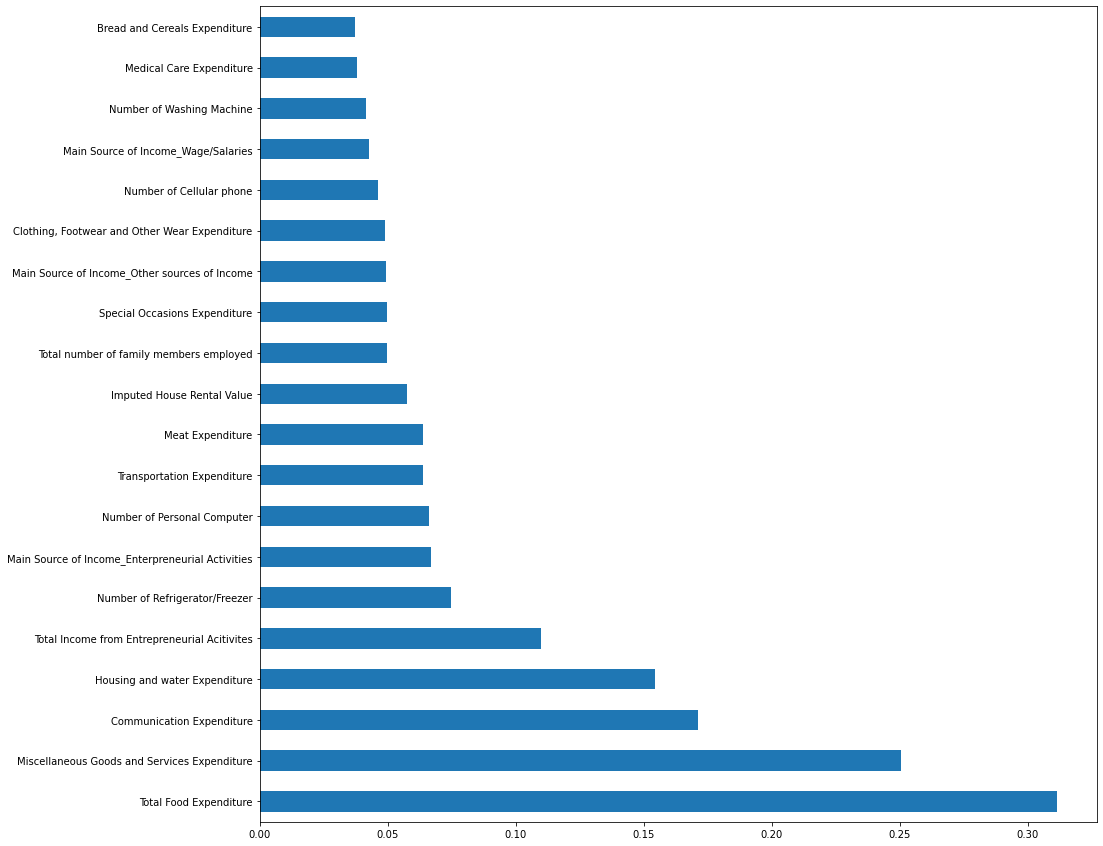

In [13]:
feature_importances = np.array([[models[i].feature_importances_] for i in range(size_x*size_y)])

feat_importances = pd.Series(feature_importances.sum(axis=0).ravel(), index=features)
plt.figure(figsize=(15, 15))
f = feat_importances.nlargest(20)
f.plot(kind='barh')
plt.show()